# Partial Coherence
**Learning how to consider partially coherent X-rays/electron or any other form of experimental decoherence.**

Real experimental data almost always comes with some form experimental uncertainty for example in the form of decoherence that arises from a partially coherent X-ray/electron source, instabilities in the scanning or imperfect detection of the diffraction intensities. All these experimental considerations will lead to a "bluring" or loss in speckle visibility in the diffraction data. While it is impossible to eliminate all kinds of experimental noise, decoherence effects can be considered in ptychography by adoption the so called mixed-state model, where the diffracted intensities $I_k$ are described by an incoherent sum over a given number of probe modes $P^{(l)}$ 

$$
I_k = \sum_l \left|\mathcal{F}\left[P^{(l)} O_k\right]\right|^2
$$

see the original article on [Mixed-state ptychography](https://doi.org/10.1038/nature11806) for more details. PtyPy supports both probe and object modes in all its engines. 

## Mixed-state reconstruction

Revisiting the earlier nanogold dataset from I08-1, we can now use the ```coherence``` parameter from the ```"BlockFull"``` scan model to specify that we would like to reconstruct our data using $5$ probe modes

```python
p.scans.scan_00.coherence = u.Param()
p.scans.scan_00.coherence.num_probe_modes = 5
p.scans.scan_00.coherence.num_object_modes = 1
```

but otherwise keeping the same set of parameters as used for the tutorial on [Working With Large Data](./01_working_with_large_data.ipynb) and after 200 iterations of DM we get a similar reconstruction but now with 5 different probe modes

![](./_assets/i08_nanogold_recons_dm_modes.png)

## How to interpret probe modes

As we can see above, the mixed-state algorithms in PtyPy provide 5 different probe modes but without constraining them into any basis. However, in order to interpret something from these probe modes we need to provide a basis with the most common choice being the enforcement of a orthonormal relationship between each mode. Ptypy's ```ortho``` function will orthonormalise our 5 probe modes that we can extract from the probe storage using ```P.probe.S["Sscan_00G00"].data```

```python
e,v = ptypy.utils.ortho(P.probe.S["Sscan_00G00"].data)
```

and returns the eigenvalues ```e``` and eigenvectors ```v```. We can now use look at the orthonormalised probe modes and their corresponding relative power by making a matplotlib figure 

```python
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=5, nrows=2,figsize=(15,6))
for i in range(5):
    axes[0,i].set_title("{:.2f} %".format(e[i]*100.))
    ax1 = ptypy.utils.PtyAxis(axes[0,i],channel="c")
    ax1.set_data(v[i][200:-200,200:-200])
    ax2 = ptypy.utils.PtyAxis(axes[1,i],channel="a")
    ax2.set_data(v[i][200:-200,200:-200])
```

using ```PtyAxis``` with channels ```"c"``` and ```"a"``` to create a plot with the first row showing a complex-valued representation and the second row the magnitudes of the probe modes, both cropped by 200 pixels on all sides:

![](./_assets/i08_nanogold_modes.png)

which shows that  $91.85 \%$ of the total power of the X-ray beam is in the main and the rest of it is distributed among the other modes. Be careful when interpreting probe modes always considering the different possible sources for partial coherence (beam, sample, detector). Very often, besides providing a more accurate picture of the illumination, using probe modes can act like a "garbage collector" providing better quality in the object reconstruction compare to a single mode reconstruction. In this particular case, the improvements in the object reconstruction are minimal and difficult to see by eye. 

`````{admonition} Challenge 
:class: attention
Adjust the number of probe modes used in the reconstruction and observe the results. What is the optimal number of probe modes for this particular example, i.e. at which point does the highest mode become insignificant (just noise) ? 
`````

---

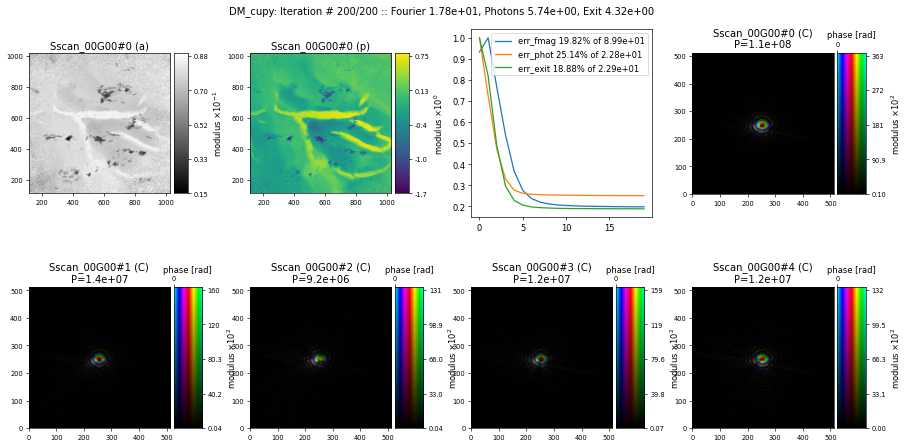


==== This reconstruction relied on the following work ==========================
The Ptypy framework:
    Enders B. and Thibault P., "A computational framework for ptychographic reconstructions" Proc. Royal Soc. A 472 (2016) 20160640, doi: 10.1098/rspa.2016.0640.
The difference map reconstruction algorithm:
    Thibault et al., "Probe retrieval in ptychographic coherent diffractive imaging" Ultramicroscopy 109 (2009) 338, doi: 10.1016/j.ultramic.2008.12.011.


<Figure size 640x480 with 0 Axes>

In [1]:
import ptypy, os
import ptypy.utils as u

# This will import the HDF5Loader class
ptypy.load_ptyscan_module("hdf5_loader")

# This will import the GPU engines
ptypy.load_gpu_engines("cupy")  

# Root directory of tutorial data
tutorial_data_home = "../../data/"

# Dataset for this tutorial
dataset = "dls_i08_nanogold_spiral/i08-1-5776_cropped.h5"

# Absolute path to HDF5 file with raw data
path_to_data = os.path.join(tutorial_data_home, dataset)

# Create parameter tree
p = u.Param()

# Set verbose level to info
p.verbose_level = "interactive"

# Scan label
p.run = "dls_i08_nanogold"

# Data loading and processing should 
# happen in chunks of this size
p.frames_per_block = 100

# Set io settings (no files saved)
p.io = u.Param()
p.io.rfile = None
p.io.autosave = u.Param(active=False)
p.io.interaction = u.Param(active=False)

# Live-plotting during the reconstruction
p.io.autoplot = u.Param()
p.io.autoplot.active=True
p.io.autoplot.threaded = False
p.io.autoplot.layout = "jupyter"
p.io.autoplot.interval = 10

# Define the scan model
p.scans = u.Param()
p.scans.scan_00 = u.Param()
p.scans.scan_00.name = 'BlockFull'

# Initial illumination (based on simulated optics)
p.scans.scan_00.illumination = u.Param()
p.scans.scan_00.illumination.model = None
p.scans.scan_00.illumination.photons = None
p.scans.scan_00.illumination.aperture = u.Param()
p.scans.scan_00.illumination.aperture.form = "circ"
p.scans.scan_00.illumination.aperture.size = 333e-6
p.scans.scan_00.illumination.propagation = u.Param()
p.scans.scan_00.illumination.propagation.focussed = 13.725e-3
p.scans.scan_00.illumination.propagation.parallel = 45e-6
p.scans.scan_00.illumination.propagation.antialiasing = 1
p.scans.scan_00.illumination.diversity = u.Param()
p.scans.scan_00.illumination.diversity.power = 0.1
p.scans.scan_00.illumination.diversity.noise = [0.5,1.0]

# Initial object
p.scans.scan_00.sample = u.Param()
p.scans.scan_00.sample.model = None
p.scans.scan_00.sample.diversity = None
p.scans.scan_00.sample.process = None

# Coherence parameters (modes)
p.scans.scan_00.coherence = u.Param()
p.scans.scan_00.coherence.num_probe_modes = 5
p.scans.scan_00.coherence.num_object_modes = 1

# Data loader
p.scans.scan_00.data = u.Param()
p.scans.scan_00.data.name = 'Hdf5Loader'
p.scans.scan_00.data.orientation = 2

p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = path_to_data
p.scans.scan_00.data.intensities.key = "data"

p.scans.scan_00.data.positions = u.Param()
p.scans.scan_00.data.positions.file = path_to_data
p.scans.scan_00.data.positions.slow_key = "posy"
p.scans.scan_00.data.positions.slow_multiplier = 1e-3
p.scans.scan_00.data.positions.fast_key = "posx"
p.scans.scan_00.data.positions.fast_multiplier = 1e-3

p.scans.scan_00.data.darkfield = u.Param()
p.scans.scan_00.data.darkfield.file = path_to_data
p.scans.scan_00.data.darkfield.key = "dark"

p.scans.scan_00.data.energy = 0.710
p.scans.scan_00.data.distance = 0.072
p.scans.scan_00.data.psize = 11e-6
p.scans.scan_00.data.shape = (1024,1024)
p.scans.scan_00.data.rebin = 2

# Reconstruct using GPU-accelerated DM
p.engines = u.Param()
p.engines.engine = u.Param()
p.engines.engine.name = "DM_cupy"
p.engines.engine.numiter = 200
p.engines.engine.numiter_contiguous = 10
p.engines.engine.probe_support = None
p.engines.engine.probe_update_start = 0
p.engines.engine.probe_fourier_support = None
p.engines.engine.record_local_error = False
p.engines.engine.alpha = 0.95
p.engines.engine.fourier_power_bound = 0.25
p.engines.engine.overlap_converge_factor = 0.001
p.engines.engine.overlap_max_iterations = 20
p.engines.engine.update_object_first = False
p.engines.engine.obj_smooth_std = 20
p.engines.engine.object_inertia = 0.001
p.engines.engine.probe_inertia = 0.001
p.engines.engine.clip_object = [0,1]

# Run reconstruction
P = ptypy.core.Ptycho(p,level=5)

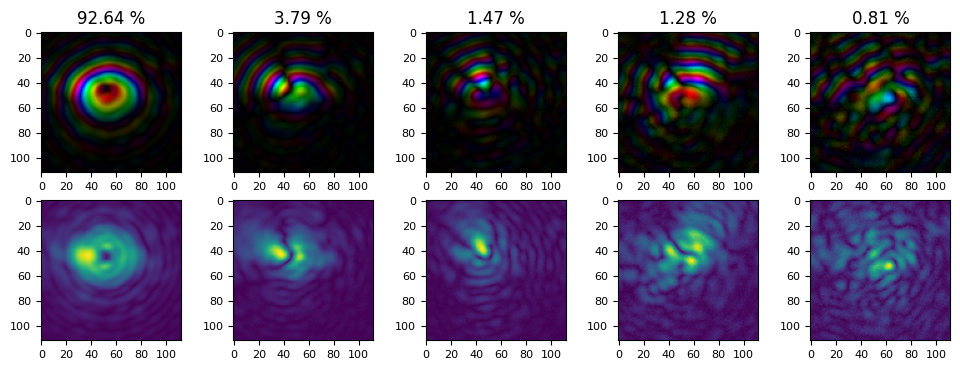

In [3]:
e,v = ptypy.utils.ortho(P.probe.S["Sscan_00G00"].data)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=5, nrows=2,figsize=(12,4))
for i in range(5):
    axes[0,i].set_title("{:.2f} %".format(e[i]*100.))
    ax1 = ptypy.utils.PtyAxis(axes[0,i],channel="c")
    ax1.set_data(v[i][200:-200,200:-200])
    ax2 = ptypy.utils.PtyAxis(axes[1,i],channel="a")
    ax2.set_data(v[i][200:-200,200:-200])